# Encoder-Decoder LSTM Model

In [44]:
import seaborn as sns

import pandas as pd
from pandas import read_csv

import numpy as np
from numpy import split
from numpy import array

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model

from math import sqrt
from datetime import datetime
from matplotlib import pyplot


Helper functions used in this process.

In [45]:
# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard 6 hour intervals
    train = data[0:-677]
    test = data[-677:-23]
    # restructure data into windows of 6 hours
    train = array(split(train, len(train)/6), dtype=object)
    test = array(split(test, len(test)/6), dtype=object)
    return train, test


We will use the first three months of data for training predictive models and the final month for evaluating models.

In [46]:
# evaluate one or more daily forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each hour
    for i in range(actual.shape[1]):
        # calculate MSE
        mse = mean_squared_error([reverse_minmaxscaler(x) for x in actual[:, i]], [
                                 reverse_minmaxscaler(x) for x in predicted[:, i]])
        # calculate RMSE
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (reverse_minmaxscaler(actual[row, col]) -
                  reverse_minmaxscaler(predicted[row, col]))**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

# summarize scores


def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.6f] %s' % (name, score, s_scores))

# convert history into inputs and outputs


def to_supervised(train, n_input, n_out=6):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, [0, 10, 11, 12]]
            X.append(x_input)
            # X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)

# train the model


def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # https://stackoverflow.com/questions/58636087/tensorflow-valueerror-failed-to-convert-a-numpy-array-to-a-tensor-unsupporte
    train_x = np.asarray(train_x).astype(np.float32)
    train_y = np.asarray(train_y).astype(np.float32)
    # define parameters
    verbose, epochs, batch_size = 0, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # define model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(50, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(20, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    plot_model(model, to_file='./plot_enc_dec_lstm.png',
               show_shapes=True, show_layer_names=True)
    # fit network
    model.fit(train_x, train_y, epochs=epochs,
              batch_size=batch_size, verbose=verbose)
    return model

# make a forecast


def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, [0, 10, 11, 12]]
    # reshape into [1, n_input, n]
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    # https://stackoverflow.com/questions/58636087/tensorflow-valueerror-failed-to-convert-a-numpy-array-to-a-tensor-unsupporte
    input_x = np.asarray(input_x).astype(np.float32)
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

# evaluate a single model


def evaluate_model(train, test, n_input):
    # fit model
    model = build_model(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores, predictions


In [47]:
# load the new file
dataset = read_csv('./processed_datasets/dogecoin_price_sentiments_hours.csv', header=0,
                   infer_datetime_format=True, parse_dates=['timestamp'], index_col=['timestamp']).dropna()

max_val = max(dataset['dogecoin_price'])
min_val = min(dataset['dogecoin_price'])

scaler = MinMaxScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(
    dataset), columns=dataset.columns, index=dataset.index)


def reverse_minmaxscaler(scaled_val):
    og_val = (scaled_val*(max_val - min_val)) + min_val
    return og_val


# split into train and test
train, test = split_dataset(scaled_data.values)

score_n = {}
scores_n = {}
predictions_n = {}

for n_input in range(6, 30, 6):
    print('n_input: ', n_input)
    score, scores, predictions = evaluate_model(train, test, n_input)
    score_n[n_input] = np.asarray(score)
    scores_n[n_input] = np.asarray(scores)
    predictions_n[n_input] = np.asarray(predictions)


n_input:  6
n_input:  12
n_input:  18
n_input:  24


Summarize the scores

In [48]:
summarize_scores('lstm', score_n[6], scores_n[6])


lstm: [0.043105] 0.0, 0.0, 0.0, 0.0, 0.0, 0.0


Plot the scores

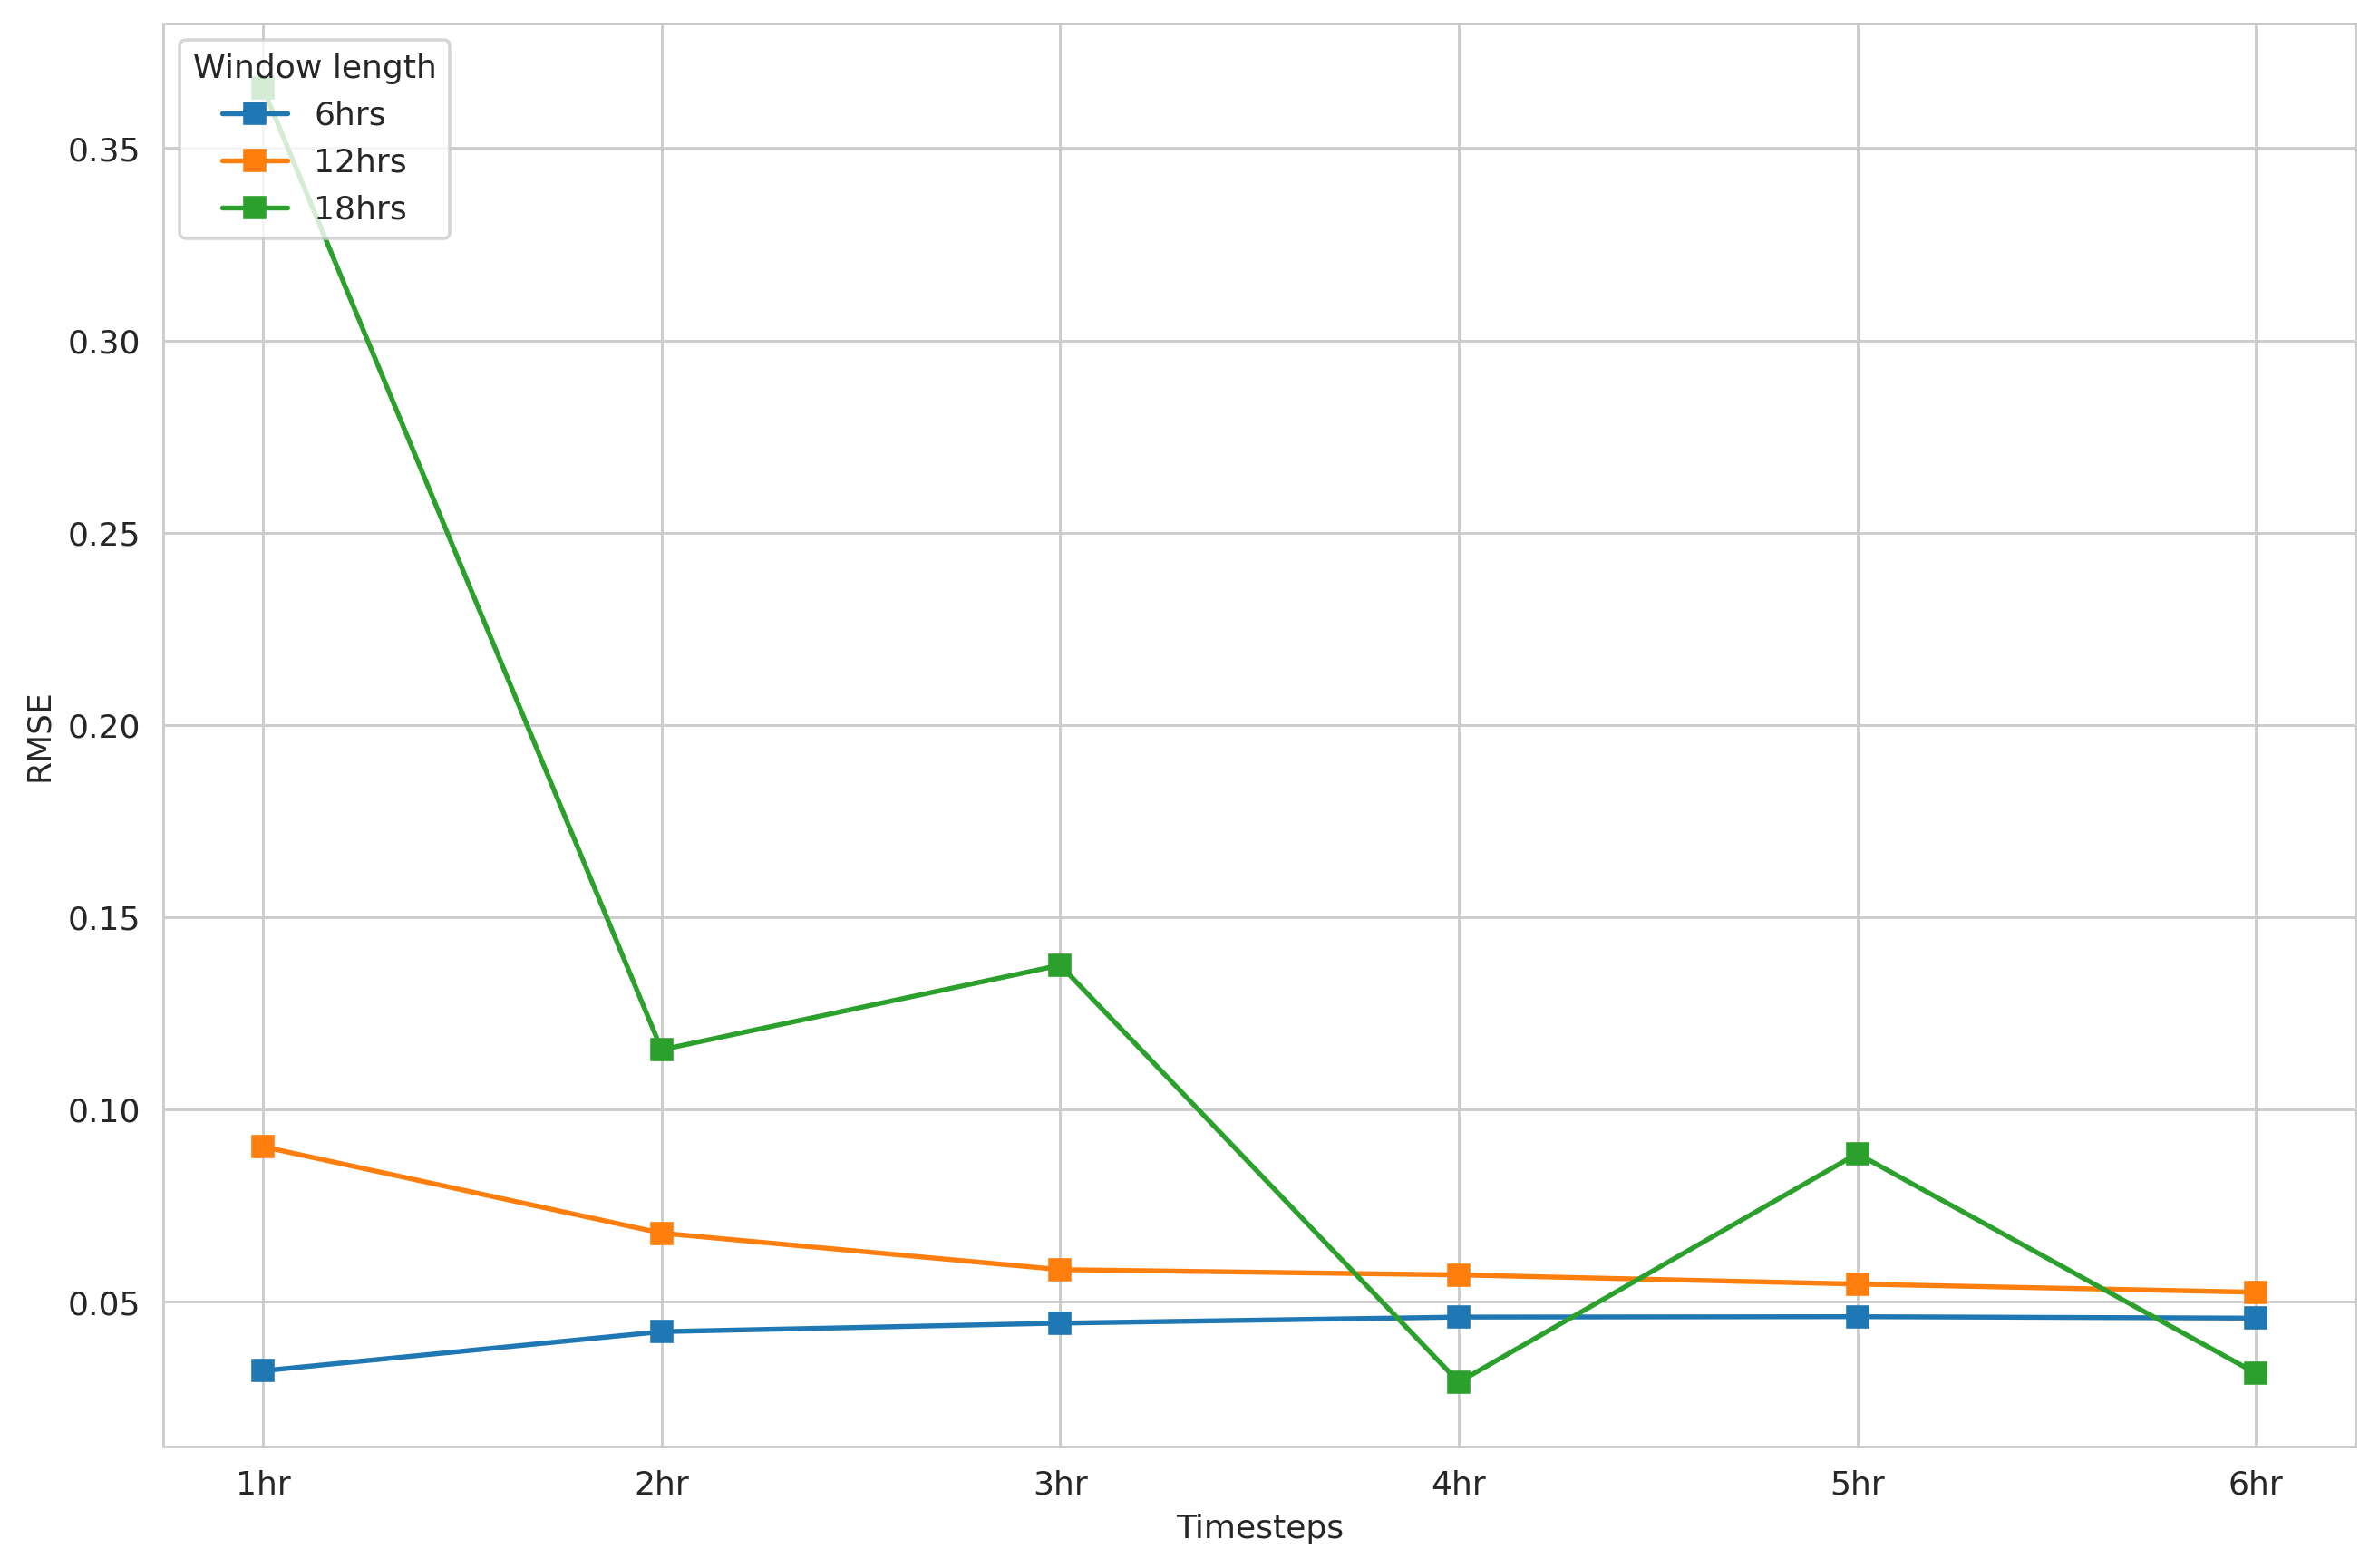

In [49]:
sns.set_style("whitegrid")
pyplot.figure(figsize=(12, 8), dpi=260)

# plot scores
days = ['1hr', '2hr', '3hr', '4hr', '5hr', '6hr']
pyplot.plot(days, scores_n[6], marker='s', label='6hrs')
pyplot.plot(days, scores_n[12], marker='s', label='12hrs')
pyplot.plot(days, scores_n[18], marker='s', label='18hrs')
pyplot.legend(loc="upper left", title="Window length")
pyplot.xlabel('Timesteps')
pyplot.ylabel('RMSE')

pyplot.show()


Plot the predictions

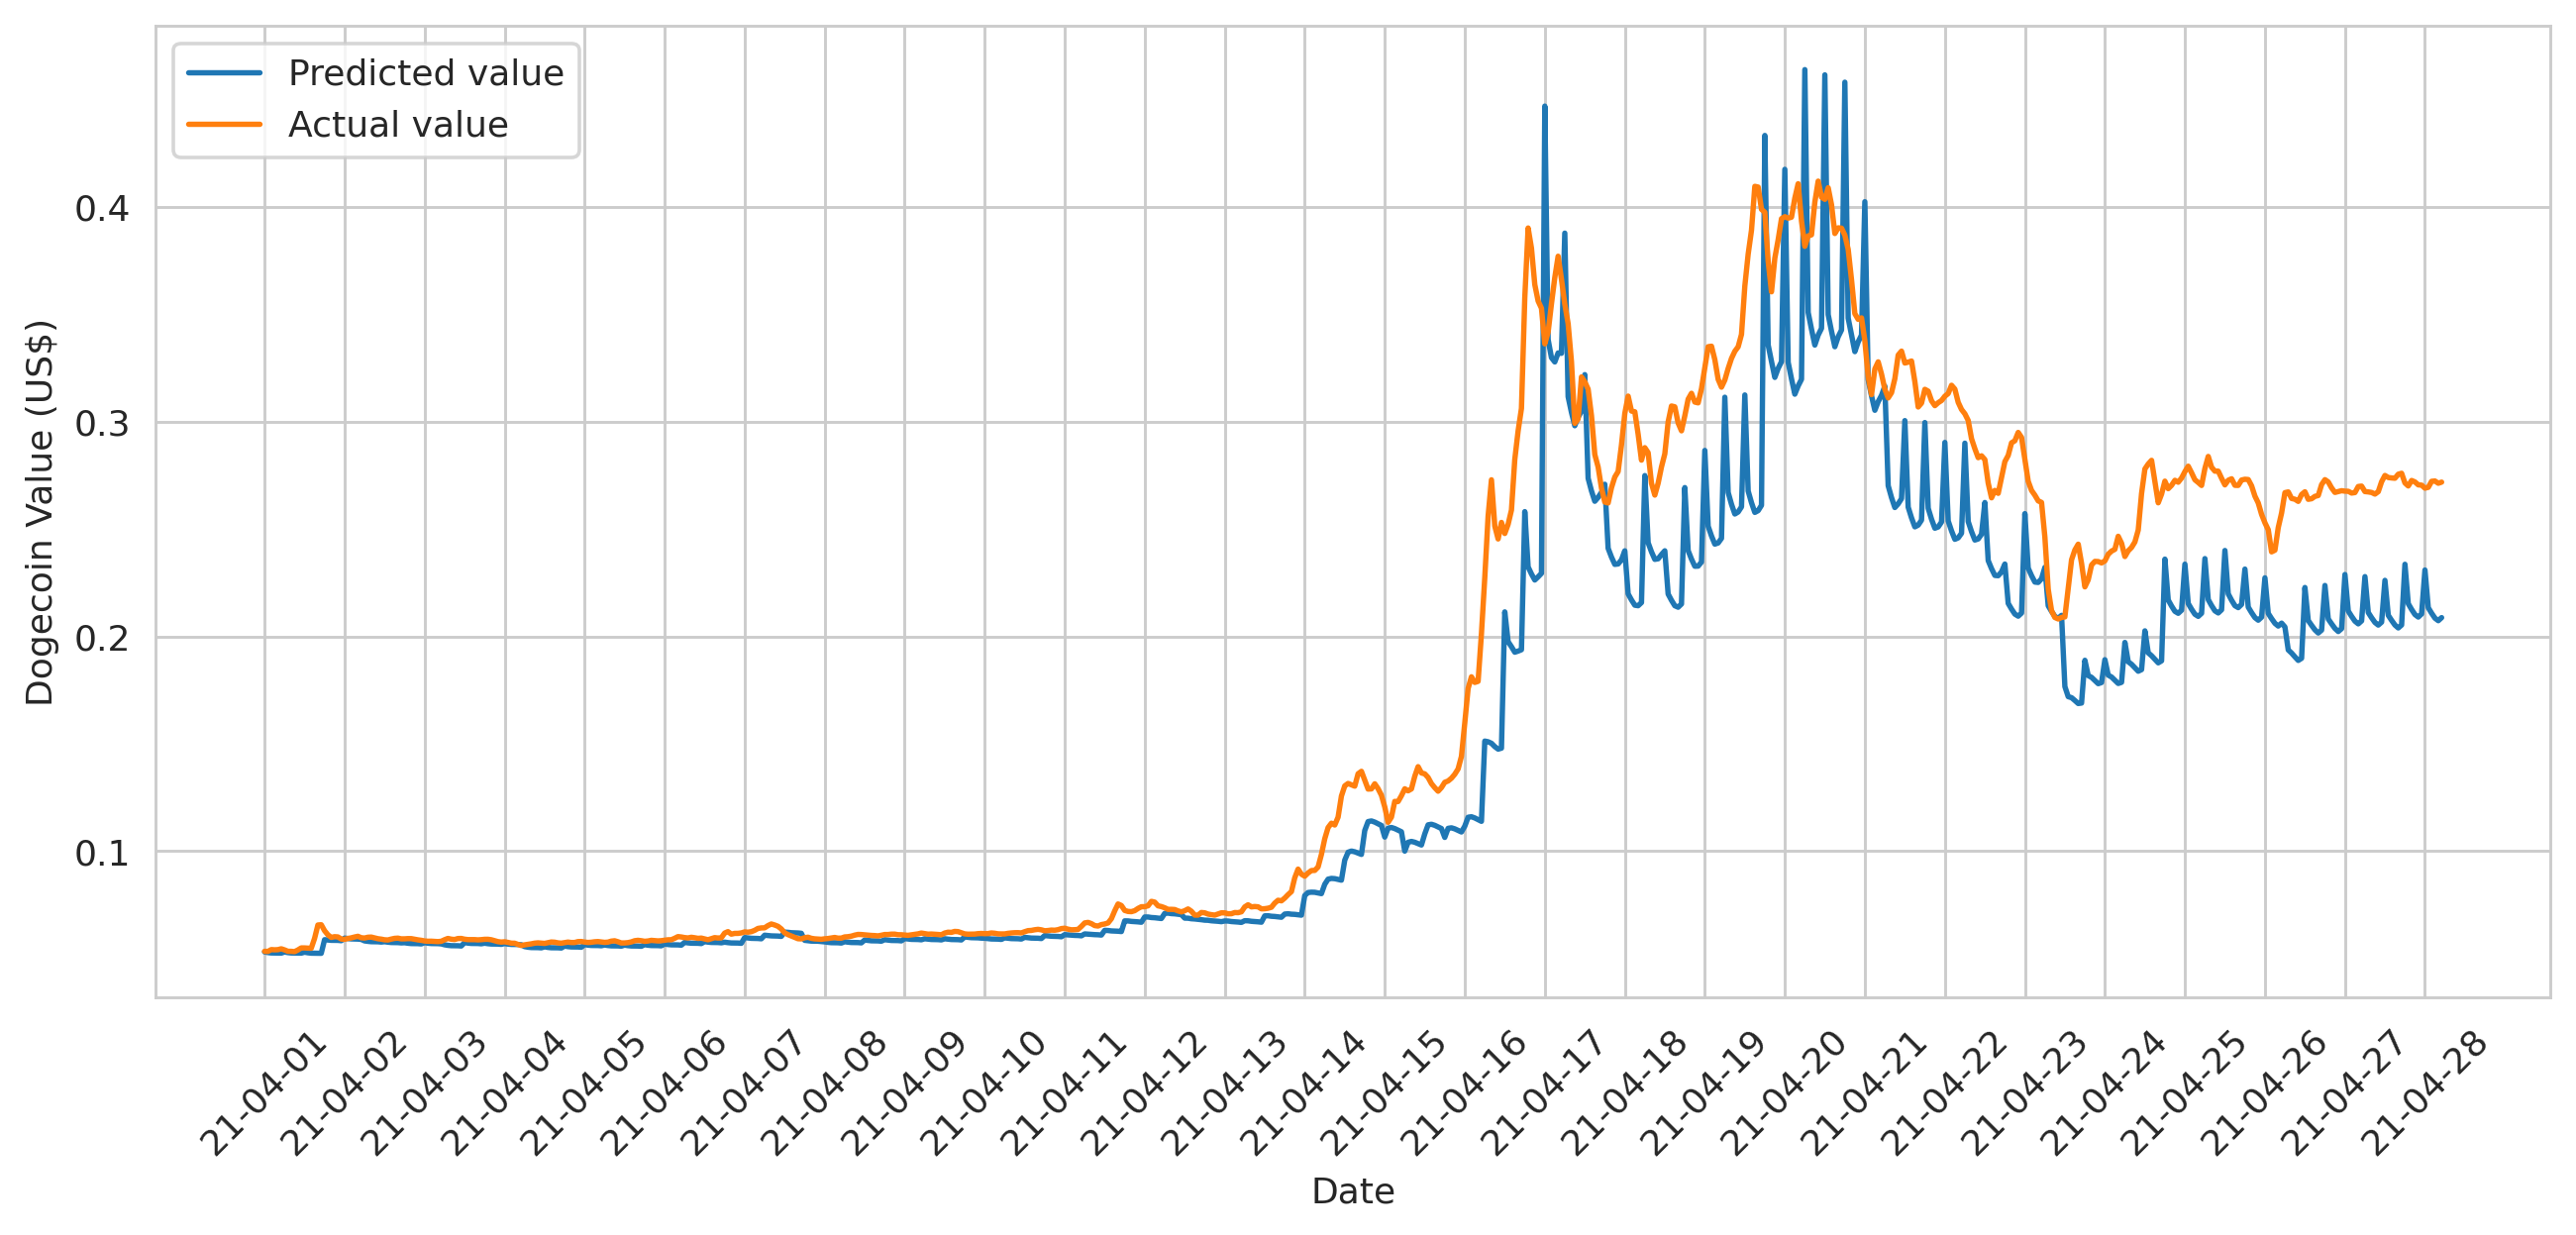

In [54]:
# take the 2nd hour predictions
prd_6 = predictions_n[6].flatten()
prd_12 = predictions_n[12].flatten()
prd_18 = predictions_n[18].flatten()
tst = test[:, :, 0].flatten()

prd_rev = [reverse_minmaxscaler(x) for x in prd_6]
tst_rev = [reverse_minmaxscaler(x) for x in tst]

sns.set_style("whitegrid")

pyplot.figure(figsize=(12, 5), dpi=260)
pyplot.plot(prd_rev, label='Predicted value')
pyplot.plot(tst_rev, label='Actual value')
pyplot.xticks(range(0, 654, 24), [
    datetime.fromtimestamp(1617235200+(ts*3600)).strftime('%y-%m-%d') for ts in range(0, 654, 24)
], rotation='45')
pyplot.xlabel('Date')
pyplot.ylabel('Dogecoin Value (US$)')
pyplot.legend(loc="upper left")
pyplot.show()


More evaluations

In [51]:

rmse = sqrt(mean_squared_error(tst, prd_6))
print('Test RMSE: %.6f' % rmse)

mae = mean_absolute_error(tst, prd_6)
print('Test MAE: %.6f' % mae)

mape = mean_absolute_percentage_error(tst, prd_6)
print('Test MAPE: %.6f' % mape)


Test RMSE: 0.105823
Test MAE: 0.070515
Test MAPE: 0.127120
